# 07 — User Profile Vectors

Build and compare user profile vectors using **Word2Vec** and **SBERT-MPNet**.

**Steps:**
1. Load article pool + reading log from notebook 06
2. Restore clicked articles on each user
3. Embed pool with Word2Vec → build W2V profiles
4. Embed pool with SBERT-MPNet (raw) → build SBERT profiles
5. Compare profile separation quality side by side
6. Save best profiles for the recommender

In [4]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

from user_profile import SYNTHETIC_USERS
from profile_builder import build_profile_vectors, save_profiles
from embeddings import load_word2vec, load_sbert, embed_corpus, load_embeddings

# Load article pool and reading log from notebook 06
df_pool     = pd.read_csv('../data/processed/article_pool.csv')
reading_log = pd.read_csv('../data/processed/reading_log.csv')

print('Pool:', df_pool.shape)
print('Reading log:', reading_log.shape)

Pool: (34770, 5)
Reading log: (40, 5)


## Step 1 — Restore clicked articles on each user

In [5]:
# Re-attach clicked article indices from reading log
for user in SYNTHETIC_USERS:
    user.clicked_articles = reading_log[
        reading_log['user_id'] == user.user_id
    ]['article_id'].tolist()
    print(f'{user.user_id} ({user.sector}): {len(user.clicked_articles)} articles')

User_1 (Construction): 10 articles
User_2 (Construction): 10 articles
User_3 (Banking): 10 articles
User_4 (Energy): 10 articles


## Step 2 — Word2Vec Profile Vectors

In [7]:
from embeddings import train_word2vec, embed_corpus
import pandas as pd

# Reload training corpus and retrain directly — avoids numpy pickle compatibility issue
df_cnhpsx = pd.read_csv('../data/processed/cnhpsx_clean.csv')
df_news   = pd.read_csv('../data/processed/pakistan_news_clean.csv')

w2v_corpus = list(df_cnhpsx['headline_clean'].dropna()) + list(df_news['text_clean'].dropna())
print(f'Training corpus: {len(w2v_corpus)} texts')

w2v_model = train_word2vec(
    texts=w2v_corpus,
    vector_size=100,
    window=5,
    min_count=2,
    epochs=10,
    save_path='../data/processed/word2vec.model'
)

# Embed full pool with Word2Vec
pool_embeddings_w2v = embed_corpus(
    texts=list(df_pool['text_for_embedding'].fillna('')),
    method='word2vec',
    model=w2v_model,
    save_path='../data/processed/embeddings_pool_w2v.npy'
)
print('W2V pool embeddings shape:', pool_embeddings_w2v.shape)

Training corpus: 34770 texts
[Word2Vec] Tokenizing 34770 texts...
[Word2Vec] Training (vector_size=100, window=5, epochs=10)...
[Word2Vec] Vocabulary size: 15243 words
[Word2Vec] Model saved to ../data/processed/word2vec.model
[embed_corpus] Embedding 34770 texts with word2vec...


Word2Vec: 100%|█████████████████████████████████████████████████████████████████| 34770/34770 [00:05<00:00, 6358.76it/s]


[embed_corpus] Done. Shape: (34770, 100)
[embed_corpus] Saved to ../data/processed/embeddings_pool_w2v.npy
W2V pool embeddings shape: (34770, 100)


In [9]:
# Build W2V user profiles
import copy
users_w2v = copy.deepcopy(SYNTHETIC_USERS)
for user in users_w2v:
    user.clicked_articles = reading_log[
        reading_log['user_id'] == user.user_id
    ]['article_id'].tolist()

users_w2v = build_profile_vectors(
    users=users_w2v,
    embeddings=pool_embeddings_w2v,
    df_tagged=df_pool
)
save_profiles(users_w2v, '../data/processed/user_profiles_w2v.npz')

[Builder] User_1: vector from 10 articles, dim=100
[Builder] User_2: vector from 10 articles, dim=100
[Builder] User_3: vector from 10 articles, dim=100
[Builder] User_4: vector from 10 articles, dim=100
[Builder] Saved 4 profiles to ../data/processed/user_profiles_w2v.npz


## Step 3 — SBERT-MPNet Profile Vectors
We use the **raw headline** (not cleaned) — as established in notebook 05, SBERT performs better on natural language.

In [11]:
# Load SBERT-MPNet
sbert_model = load_sbert('mpnet')

# Embed pool with SBERT using raw headline (not cleaned)
sbert_pool_embeddings = embed_corpus(
    texts=list(df_pool['headline'].fillna('')),
    method='sbert',
    model=sbert_model,
    save_path='../data/processed/embeddings_pool_sbert_mpnet.npy'
)
print('SBERT pool embeddings shape:', sbert_pool_embeddings.shape)

[SBERT] Loading: all-mpnet-base-v2...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


[SBERT] Ready — embedding dim: 768
[embed_corpus] Embedding 34770 texts with sbert...


Batches:   0%|          | 0/544 [00:00<?, ?it/s]

[embed_corpus] Done. Shape: (34770, 768)
[embed_corpus] Saved to ../data/processed/embeddings_pool_sbert_mpnet.npy
SBERT pool embeddings shape: (34770, 768)


In [12]:
# Build SBERT user profiles
users_sbert = copy.deepcopy(SYNTHETIC_USERS)
for user in users_sbert:
    user.clicked_articles = reading_log[
        reading_log['user_id'] == user.user_id
    ]['article_id'].tolist()

users_sbert = build_profile_vectors(
    users=users_sbert,
    embeddings=sbert_pool_embeddings,
    df_tagged=df_pool
)
save_profiles(users_sbert, '../data/processed/user_profiles_sbert_mpnet.npz')

[Builder] User_1: vector from 10 articles, dim=768
[Builder] User_2: vector from 10 articles, dim=768
[Builder] User_3: vector from 10 articles, dim=768
[Builder] User_4: vector from 10 articles, dim=768
[Builder] Saved 4 profiles to ../data/processed/user_profiles_sbert_mpnet.npz


## Step 4 — Compare Profile Separation
A good profile model should:
- Score **high** similarity between users of the **same sector** (User_1 vs User_2)
- Score **low** similarity between users of **different sectors** (User_1 vs User_3, User_1 vs User_4)

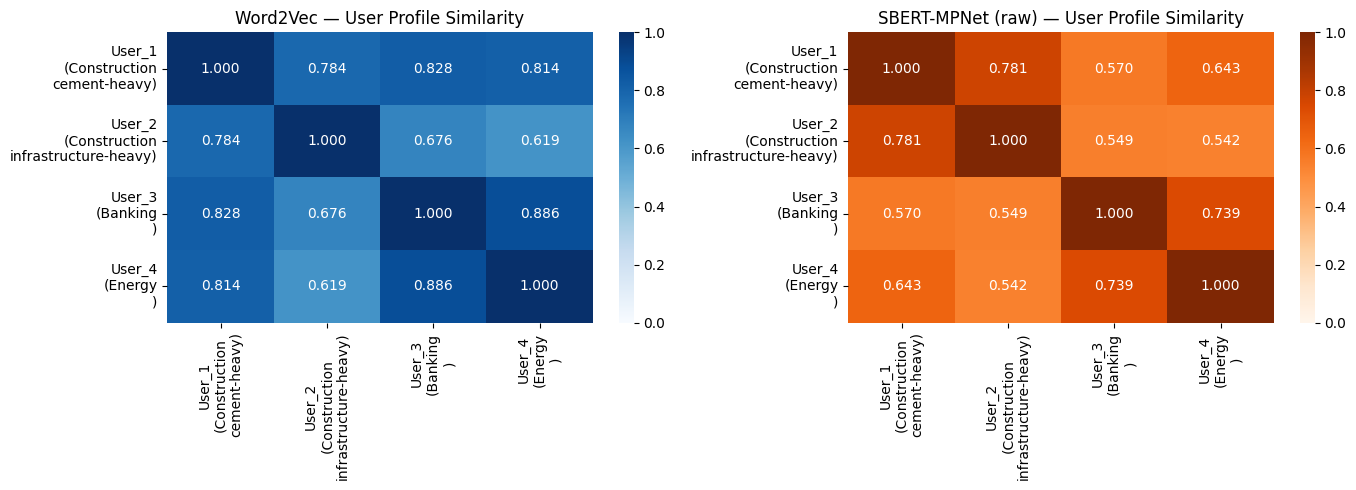

In [13]:
labels = [f"{u.user_id}\n({u.sector}\n{u.sub_focus or ''})" for u in SYNTHETIC_USERS]

vec_w2v   = np.array([u.profile_vector for u in users_w2v])
vec_sbert = np.array([u.profile_vector for u in users_sbert])

sim_w2v   = cosine_similarity(vec_w2v)
sim_sbert = cosine_similarity(vec_sbert)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(sim_w2v, annot=True, fmt='.3f',
    xticklabels=labels, yticklabels=labels,
    cmap='Blues', vmin=0, vmax=1, ax=axes[0])
axes[0].set_title('Word2Vec — User Profile Similarity')

sns.heatmap(sim_sbert, annot=True, fmt='.3f',
    xticklabels=labels, yticklabels=labels,
    cmap='Oranges', vmin=0, vmax=1, ax=axes[1])
axes[1].set_title('SBERT-MPNet (raw) — User Profile Similarity')

plt.tight_layout()
plt.show()

In [14]:
# Quantify separation quality for each model
# Delta = similarity(same sector) - mean(similarity(different sectors))

def separation_score(sim_matrix):
    # User_1 vs User_2 = same sector (Construction)
    same    = sim_matrix[0, 1]
    # User_1 vs User_3 and User_1 vs User_4 = different sectors
    diff    = np.mean([sim_matrix[0, 2], sim_matrix[0, 3]])
    delta   = same - diff
    return same, diff, delta

same_w2v,   diff_w2v,   delta_w2v   = separation_score(sim_w2v)
same_sbert, diff_sbert, delta_sbert = separation_score(sim_sbert)

results = pd.DataFrame({
    'Same sector (U1 vs U2)':  [round(same_w2v, 4),   round(same_sbert, 4)],
    'Diff sector (mean)':      [round(diff_w2v, 4),   round(diff_sbert, 4)],
    'Δ separation':            [round(delta_w2v, 4),  round(delta_sbert, 4)],
}, index=['Word2Vec', 'SBERT-MPNet (raw)'])

print('=== Profile Separation Comparison ===')
print(results.to_string())
best = results['Δ separation'].idxmax()
print(f'\n→ Best model for user profiling: {best} (Δ = {results.loc[best, "Δ separation"]})')

=== Profile Separation Comparison ===
                   Same sector (U1 vs U2)  Diff sector (mean)  Δ separation
Word2Vec                           0.7842              0.8210       -0.0368
SBERT-MPNet (raw)                  0.7811              0.6062        0.1749

→ Best model for user profiling: SBERT-MPNet (raw) (Δ = 0.17489999532699585)


## Step 5 — Save Best Profiles for Recommender

In [15]:
# Save both — the recommender will use the same model as the profile
# (W2V profiles → W2V article embeddings, SBERT profiles → SBERT article embeddings)
print('Both profile sets already saved:')
print('  data/processed/user_profiles_w2v.npz')
print('  data/processed/user_profiles_sbert_mpnet.npz')
print('\nThe recommender (notebook 08) will run with both and compare results.')

Both profile sets already saved:
  data/processed/user_profiles_w2v.npz
  data/processed/user_profiles_sbert_mpnet.npz

The recommender (notebook 08) will run with both and compare results.


## Conclusions
- [ ] W2V pool embeddings shape: ...
- [ ] SBERT pool embeddings shape: ...
- [ ] W2V same/diff/Δ: ...
- [ ] SBERT same/diff/Δ: ...
- [ ] Best model for profiling: Word2Vec / SBERT-MPNet
- [ ] Ready for recommender (notebook 08): yes/no